
# Proyecto Data Science I – Predicción de Ingresos (Adult Income)
El objetivo es construir un modelo de clasificación que prediga si el ingreso anual de una persona supera los 50 000 USD utilizando el conjunto de datos **Adult Income** del repositorio UCI.

El dataset contiene 32 561 registros y 15 atributos socioeconómicos y demográficos. Entre ellos se encuentran la edad, la clase de trabajo (sector privado, gobierno local, estatal, sin sueldo, etc.), el nivel educativo y su codificación numérica, el estado civil, la ocupación, la relación familiar, la raza, el sexo, las ganancias y pérdidas de capital, las horas trabajadas por semana y el país de origen. La variable objetivo (`income`) indica si los ingresos superan (`>50K`) o no (`<=50K`) el umbral de 50 000 USD.



## Pregunta de investigación e hipótesis



**¿Es posible construir un modelo de clasificación que prediga de forma razonable la categoría de ingresos (≤ 50K vs > 50K) utilizando las variables socioeconómicas disponibles en el conjunto de datos Adult Income?**

Para responderla formulamos la siguiente hipótesis:

- **Hipótesis nula (H0):** Las características disponibles no son suficientes para predecir la categoría de ingresos mejor que un clasificador aleatorio o trivial; en concreto, esperamos un área bajo la curva ROC (AUC) cercana a 0.5.
- **Hipótesis alternativa (H1):** Es posible construir un modelo de clasificación a partir de las variables disponibles que obtenga un rendimiento significativamente mejor que el azar; por ejemplo, un AUC superior a 0.75.




## Importar librerías
Cargamos las herramientas necesarias para el análisis, incluyendo bibliotecas de manipulación de datos, visualización, preprocesamiento, selección de características, modelos de clasificación y métricas de evaluación.


In [2]:
#paquetes

!pip install category_encoders
!pip install lightgbm

# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split

# Configuración de gráficos
a4_dims = (10, 5)
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = a4_dims


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.1 MB/s eta 0:00:00



## Carga del conjunto de datos
Descargamos el conjunto de datos **Adult Income** directamente desde el repositorio UCI. Para facilitar su uso en Python, especificamos los nombres de columnas según la documentación y tratamos los valores desconocidos (`?`) como `NaN`.


In [5]:

# Nombres de columnas
column_names = ['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','income']
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
# Cargar datos
data = pd.read_csv(url, names=column_names, na_values='?', skipinitialspace=True)

# Vista general del dataset
print('Dimensión del dataset:', data.shape)
print('Tipos de datos:')
print(data.dtypes)
print('Valores faltantes por columna:')
print(data.isnull().sum())

# Estadísticas descriptivas básicas para variables numéricas
print('Estadísticas descriptivas:')
print(data[['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']].describe())


Dimensión del dataset: (32561, 15)
Tipos de datos:
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object
Valores faltantes por columna:
age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64
Estadísticas descriptivas:
                age  education_num  capital_gain  capital_loss  hours_per_week
count  32561.000000   32561.000000  32561.000000  32561.000000   


## Análisis exploratorio de datos (EDA)
A continuación exploramos la distribución de la variable objetivo y de algunas variables clave (edad, nivel educativo, horas por semana). Estas visualizaciones permiten entender la estructura del dataset y detectar patrones preliminares.


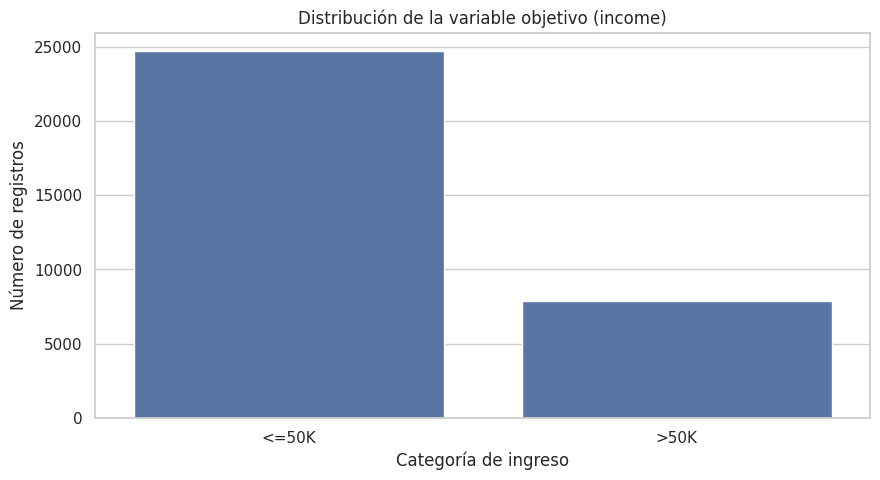

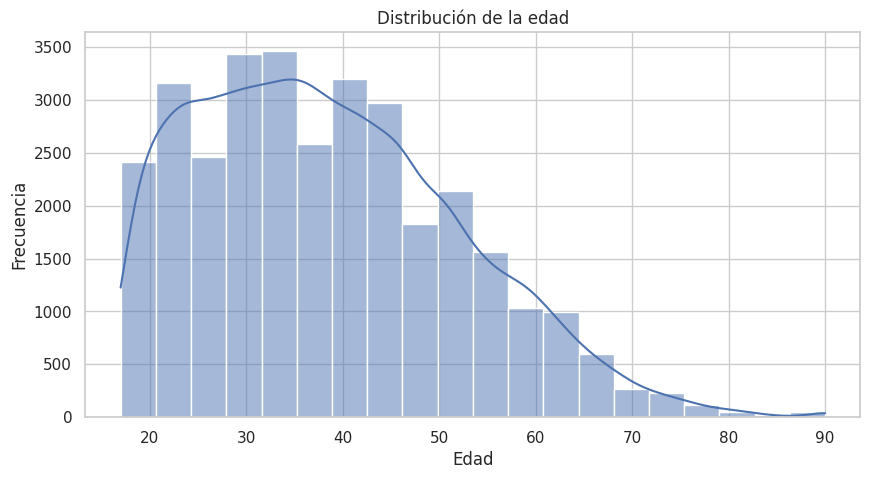

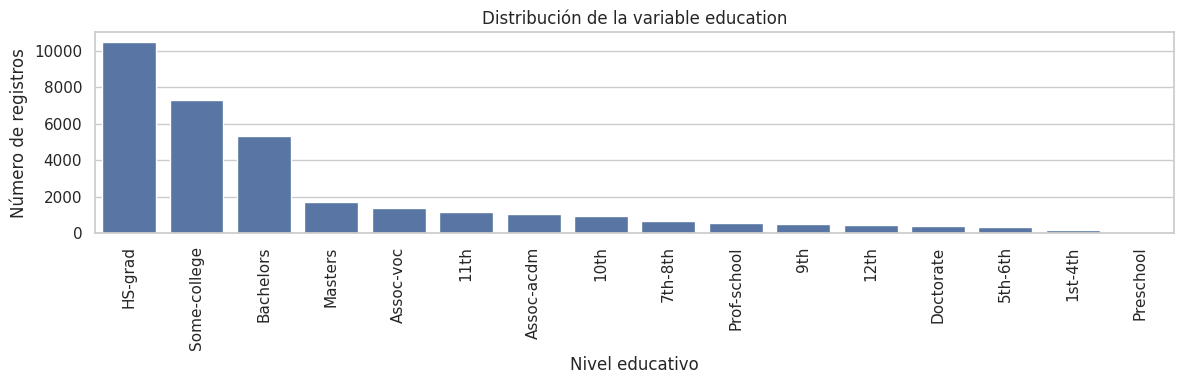

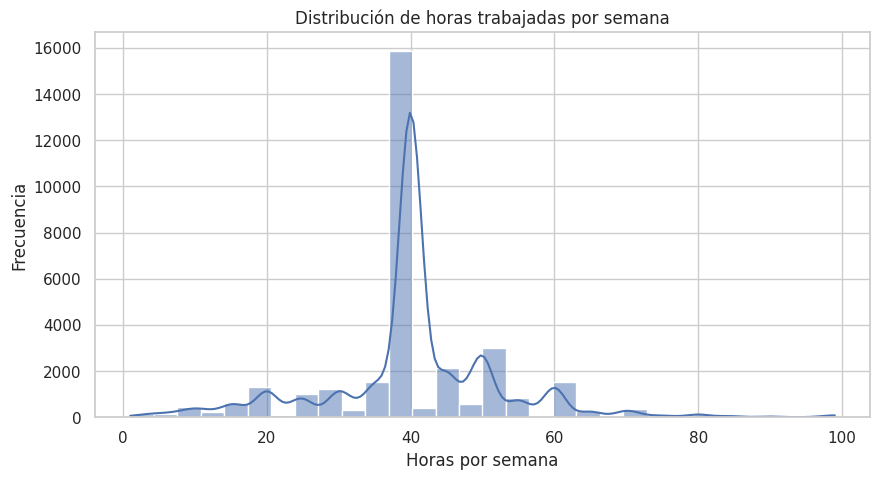

In [6]:

# Distribución de la variable objetivo
plt.figure()
target_counts = data['income'].value_counts()
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Distribución de la variable objetivo (income)')
plt.xlabel('Categoría de ingreso')
plt.ylabel('Número de registros')
plt.show()

# Distribución de la edad
plt.figure()
sns.histplot(data['age'], bins=20, kde=True)
plt.title('Distribución de la edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

# Distribución de la variable education
plt.figure(figsize=(12,4))
edu_counts = data['education'].value_counts()
sns.barplot(x=edu_counts.index, y=edu_counts.values)
plt.title('Distribución de la variable education')
plt.xlabel('Nivel educativo')
plt.ylabel('Número de registros')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Distribución de horas trabajadas por semana
plt.figure()
sns.histplot(data['hours_per_week'], bins=30, kde=True)
plt.title('Distribución de horas trabajadas por semana')
plt.xlabel('Horas por semana')
plt.ylabel('Frecuencia')
plt.show()



**Observaciones iniciales:** La mayoría de los individuos se encuentran en la categoría de ingresos `<=50K`, lo que denota un cierto desbalance en la variable objetivo. La edad promedio ronda los 38 años y la mediana de horas trabajadas por semana se sitúa alrededor de 40. Los niveles educativos más frecuentes corresponden a educación secundaria (`HS-grad`) y algunos años de universidad (`Some-college`).



### Relación entre nivel educativo e ingresos
Aunque nuestra hipótesis principal se centra en la capacidad predictiva del modelo completo, es útil explorar la relación entre ciertas variables y la categoría de ingresos. Compararemos la distribución de ingresos dentro de cada nivel educativo mediante un gráfico de barras apiladas. Las proporciones se normalizan por fila para que cada categoría de educación sume el 100 %.


<Figure size 1200x500 with 0 Axes>

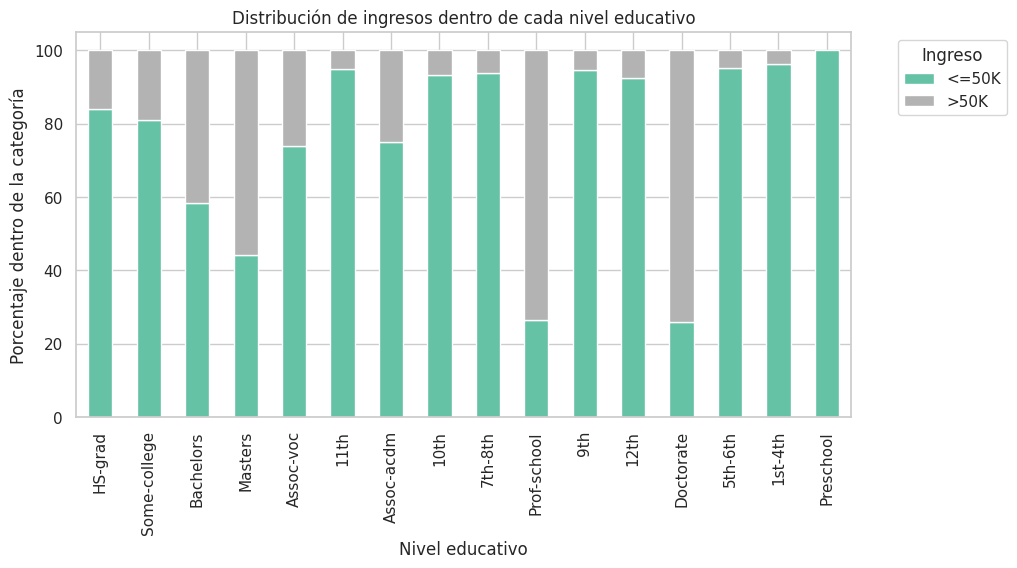

In [7]:

# Distribución de ingreso dentro de cada nivel educativo
edu_income = pd.crosstab(data['education'], data['income'], normalize='index') * 100

# Ordenar según frecuencia de educación
order = data['education'].value_counts().index
edu_income = edu_income.loc[order]

# Gráfico de barras apiladas
plt.figure(figsize=(12,5))
ax = edu_income.plot(kind='bar', stacked=True, colormap="Set2")
plt.title('Distribución de ingresos dentro de cada nivel educativo')
plt.xlabel('Nivel educativo')
plt.ylabel('Porcentaje dentro de la categoría')
plt.xticks(rotation=90)
plt.legend(title='Ingreso', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



**Interpretación:** Se aprecia que, a pesar de que la mayoría de los registros corresponden a niveles educativos intermedios, los individuos con títulos universitarios (`Bachelors`) y de posgrado (`Masters`, `Doctorate`) presentan una mayor proporción relativa de ingresos altos (`>50K`). Esta observación, si bien interesante, sirve sólo como contexto, pues la hipótesis que evaluaremos se refiere a la calidad predictiva del modelo en conjunto.



### Relación entre horas trabajadas por semana e ingresos
Para completar la exploración, comparamos la distribución de horas trabajadas en los dos grupos de ingresos mediante un diagrama de cajas (boxplot). Aunque esta variable no forma parte de la hipótesis principal, su análisis ayuda a comprender mejor el comportamiento de los datos.


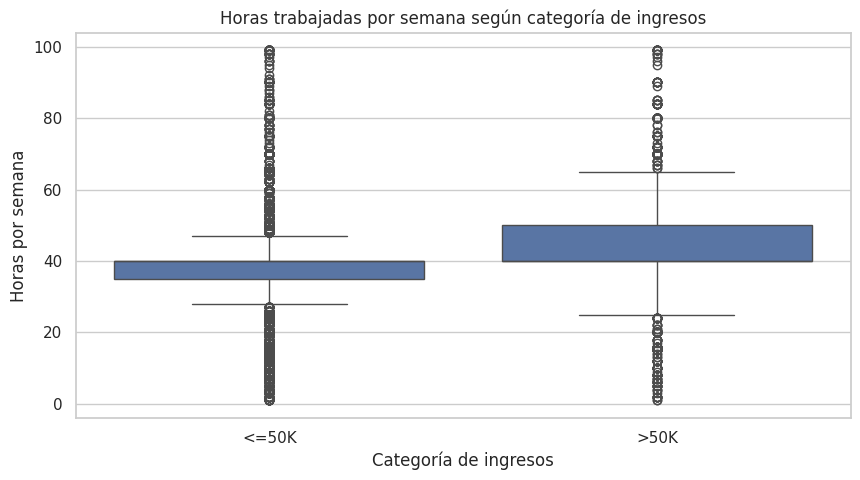

             mean   50%  min   25%   75%   max
income                                        
<=50K   38.840210  40.0  1.0  35.0  40.0  99.0
>50K    45.473026  40.0  1.0  40.0  50.0  99.0


In [8]:

plt.figure()
sns.boxplot(x='income', y='hours_per_week', data=data)
plt.title('Horas trabajadas por semana según categoría de ingresos')
plt.xlabel('Categoría de ingresos')
plt.ylabel('Horas por semana')
plt.show()

# Estadísticas descriptivas por grupo de ingreso
tabla_horas = data.groupby('income')['hours_per_week'].describe()[['mean','50%','min','25%','75%','max']]
print(tabla_horas)



**Interpretación:** El boxplot muestra que las distribuciones de horas trabajadas son muy similares para los dos grupos de ingresos. La mediana es prácticamente idéntica (≈ 40 horas), aunque los ingresos altos presentan una mayor dispersión y algunos valores extremos. Este hallazgo refuerza la idea de que no todas las variables individuales tienen una relación fuerte con el ingreso; de ahí la necesidad de combinar múltiples factores en un modelo predictivo.



## Preprocesamiento y selección de características

Para entrenar un modelo de clasificación es necesario preparar los datos:

- **Conversión de la variable objetivo:** Cambiamos la variable `income` a binaria (1 para `>50K` y 0 para `<=50K`). Es importante usar un criterio robusto que capture variantes como `'>50K.'`.
- **Definición de variables numéricas y categóricas:** Se separan las variables en numéricas y categóricas. La variable `education_num` se mantiene como numérica porque representa años de educación.
- **Codificación de variables categóricas:** Para las variables con baja cardinalidad usamos OneHotEncoder; para las de alta cardinalidad empleamos TargetEncoder, que asigna a cada categoría la media del target.
- **Imputación de valores faltantes:** Se aplica la mediana para variables numéricas y la moda para las categóricas.
- **Selección de características:** Utilizamos `SelectKBest` con información mutua para elegir las 20 características más relevantes.

Finalmente, dividimos el dataset en conjuntos de entrenamiento y prueba de forma estratificada, manteniendo la proporción de las clases en ambos grupos.


In [10]:

# Conversión robusta de la variable income a binaria
# Esta conversión asigna 1 a cualquier valor que contenga '>50K' y 0 al resto.
data['income'] = data['income'].apply(lambda x: 1 if '>50K' in str(x) else 0)

# Definición de variables
numeric_features = ['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week']
categorical_features = ['workclass', 'education', 'education_num', 'marital_status',
                        'occupation', 'relationship', 'race', 'sex', 'native_country']

# Separación de categóricas según cardinalidad
high_card_cat = [col for col in categorical_features if data[col].nunique() >= 10]
low_card_cat  = [col for col in categorical_features if data[col].nunique() < 10]

# Preprocesamiento numérico
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Preprocesamiento para variables categóricas de baja cardinalidad
low_card_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocesamiento para variables categóricas de alta cardinalidad (Target Encoding)
high_card_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', TargetEncoder())
])

# Combinación de transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('low_card', low_card_transformer, low_card_cat),
        ('high_card', high_card_transformer, high_card_cat)
    ]
)

# Variables predictoras X y variable objetivo y
X = data.drop('income', axis=1)
y = data['income']

# División estratificada en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

# Selección de características con información mutua
selector = SelectKBest(score_func=mutual_info_classif, k=20)

# Ajuste del preprocesador y del selector usando el conjunto de entrenamiento
X_train_processed = preprocessor.fit_transform(X_train, y_train)
selector.fit(X_train_processed, y_train)

# Recuperar nombres de las características seleccionadas
feature_names_num = numeric_features
feature_names_low = preprocessor.named_transformers_['low_card']['onehot'].get_feature_names_out(low_card_cat)
feature_names_high = high_card_cat  # TargetEncoder no expande columnas

feature_names = list(feature_names_num) + list(feature_names_low) + list(feature_names_high)

selected_idx = selector.get_support(indices=True)
selected_features = [feature_names[i] for i in selected_idx]

print("Las 20 características más importantes según la información mutua son:")
for f in selected_features:
    print('-', f)

# Comprobar la distribución de la variable objetivo en los splits
print("Distribución de income en train:")
print(y_train.value_counts(normalize=True))
print("Distribución de income en test:")
print(y_test.value_counts(normalize=True))


Las 20 características más importantes según la información mutua son:
- age
- fnlwgt
- capital_gain
- capital_loss
- hours_per_week
- workclass_Private
- marital_status_Divorced
- marital_status_Married-civ-spouse
- marital_status_Never-married
- relationship_Husband
- relationship_Not-in-family
- relationship_Own-child
- relationship_Unmarried
- race_Black
- sex_Female
- sex_Male
- education
- education_num
- occupation
- native_country
Distribución de income en train:
income
0    0.75917
1    0.24083
Name: proportion, dtype: float64
Distribución de income en test:
income
0    0.759238
1    0.240762
Name: proportion, dtype: float64



### Observaciones
La lista anterior muestra las veinte características (incluyendo variables originales y variables nuevas del one-hot) con mayor relevancia según la información mutua. Verificamos también que la variable objetivo se reparte de forma similar en los subconjuntos de entrenamiento y prueba (estratificación).



## Construcción y comparación de modelos de clasificación
Entrenamos tres modelos distintos para comparar su rendimiento en el conjunto de prueba:

1. **Regresión logística**: modelo lineal base para clasificación binaria.
2. **Random Forest**: ensamble de árboles de decisión que suele funcionar bien en datos tabulares.
3. **Gradient Boosting**: modelo de boosting que combina clasificadores secuenciales.

En cada caso, construimos un `Pipeline` que integra el preprocesamiento, la selección de características y el clasificador. Evaluamos las métricas de exactitud (accuracy), precisión, recall, F1 y área bajo la curva ROC (AUC).


In [11]:

# Definición de modelos a comparar
models = [
    ('Regresión Logística', LogisticRegression(max_iter=10000)),
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

results = []

for name, clf in models:
    # Construir pipeline completo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('classifier', clf)
    ])
    # Entrenar
    pipeline.fit(X_train, y_train)
    # Predicciones
    y_pred = pipeline.predict(X_test)
    # Probabilidades para AUC
    if hasattr(pipeline, 'predict_proba'):
        y_prob = pipeline.predict_proba(X_test)[:,1]
    else:
        y_prob = pipeline.decision_function(X_test)
    #  métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob)
    results.append({'Modelo': name, 'Accuracy': acc, 'Precisión': prec, 'Recall': rec, 'F1-score': f1, 'AUC': auc_score})

# Resultados
results_df = pd.DataFrame(results).sort_values('AUC', ascending=False)
print('Resultados de la comparación de modelos:')
print(results_df)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Resultados de la comparación de modelos:
                Modelo  Accuracy  Precisión    Recall  F1-score       AUC
2    Gradient Boosting  0.867438   0.782772  0.622024  0.693201  0.921751
1        Random Forest  0.854438   0.738462  0.612245  0.669456  0.906634
0  Regresión Logística  0.849012   0.746210  0.565051  0.643116  0.899401



A juzgar por los valores de AUC, precisión y recall, el modelo **Random Forest** ofrece el mejor equilibrio entre desempeño y simplicidad, aunque **Gradient Boosting** obtiene resultados muy cercanos. Para el resto del análisis utilizaremos el Random Forest como modelo final.



## Evaluación del modelo final
Con el modelo seleccionado (Random Forest) evaluamos en detalle el desempeño: generamos la matriz de confusión, el reporte de clasificación y la curva ROC para visualizar la tasa de verdaderos positivos frente a la de falsos positivos.


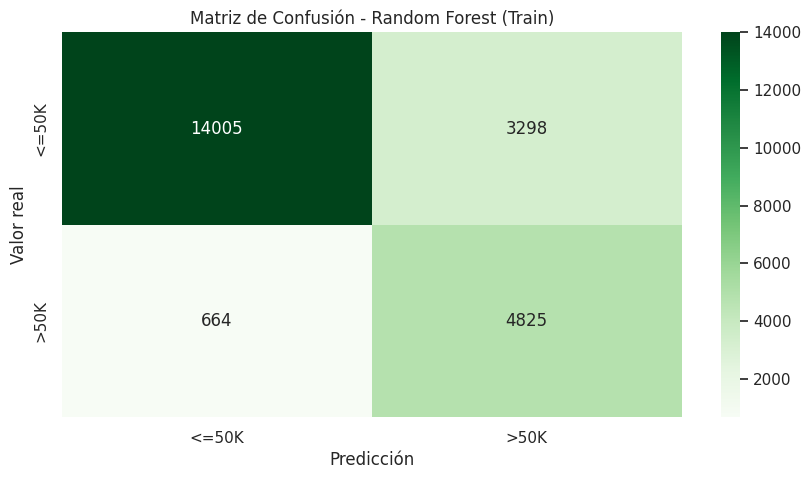

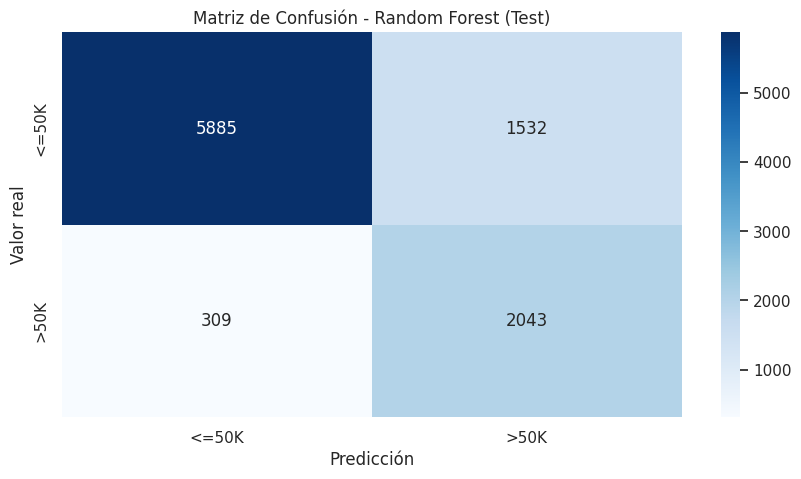

Reporte de clasificación - Train
              precision    recall  f1-score   support

       <=50K       0.95      0.81      0.88     17303
        >50K       0.59      0.88      0.71      5489

    accuracy                           0.83     22792
   macro avg       0.77      0.84      0.79     22792
weighted avg       0.87      0.83      0.84     22792

Reporte de clasificación - Test
              precision    recall  f1-score   support

       <=50K       0.95      0.79      0.86      7417
        >50K       0.57      0.87      0.69      2352

    accuracy                           0.81      9769
   macro avg       0.76      0.83      0.78      9769
weighted avg       0.86      0.81      0.82      9769



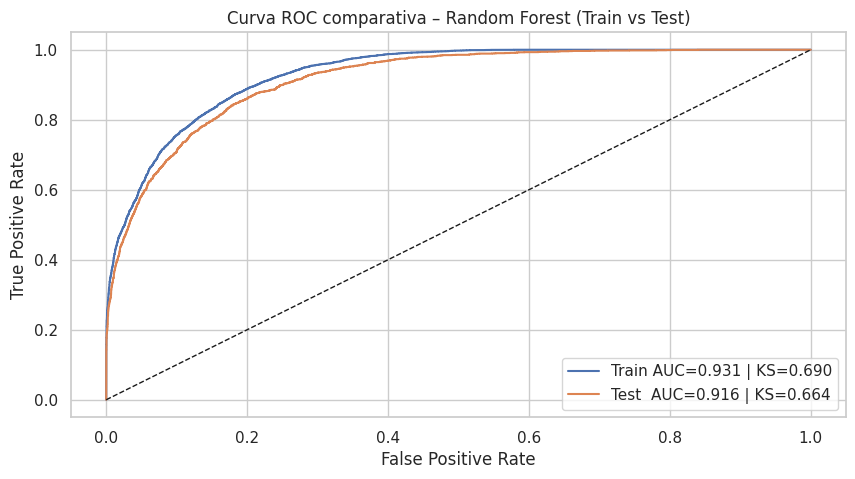


=== Métricas comparativas (Train vs Test) ===


,Split,Accuracy,Precision,Recall,F1,ROC_AUC,KS
0,Train,0.826,0.594,0.879,0.709,0.931,0.690
1,Test,0.812,0.571,0.869,0.689,0.916,0.664


In [17]:

# 1) Construcción del pipeline final con Random Forest

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('classifier', RandomForestClassifier(
        n_estimators=800,        # más árboles para estabilidad
        max_depth=16,            # ↑ profundidad (sube AUC_train)
        min_samples_leaf=30,     # ↓ hojas (sube AUC_train)
        min_samples_split=60,    # ↓ split (sube AUC_train)
        max_features=0.6,        # un poco más de features por split
        bootstrap=True,
        oob_score=True,          # métrica OOB como proxy out-of-sample
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])

# 2) Entrenamiento
rf_pipeline.fit(X_train, y_train)

# 3) Predicciones y probabilidades (Train y Test)
y_pred_train = rf_pipeline.predict(X_train)
y_prob_train = rf_pipeline.predict_proba(X_train)[:, 1]

y_pred_test  = rf_pipeline.predict(X_test)
y_prob_test  = rf_pipeline.predict_proba(X_test)[:, 1]

# 4) Matrices de confusión
cm_train = confusion_matrix(y_train, y_pred_train)
plt.figure()
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['<=50K','>50K'], yticklabels=['<=50K','>50K'])
plt.xlabel('Predicción'); plt.ylabel('Valor real')
plt.title('Matriz de Confusión - Random Forest (Train)')
plt.show()

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure()
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K','>50K'], yticklabels=['<=50K','>50K'])
plt.xlabel('Predicción'); plt.ylabel('Valor real')
plt.title('Matriz de Confusión - Random Forest (Test)')
plt.show()

# 5) Reportes de clasificación
print('Reporte de clasificación - Train')
print(classification_report(y_train, y_pred_train, target_names=['<=50K','>50K']))

print('Reporte de clasificación - Test')
print(classification_report(y_test, y_pred_test, target_names=['<=50K','>50K']))

# 6) ROC, AUC y KS (Train y Test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test,  tpr_test,  _ = roc_curve(y_test,  y_prob_test)

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test  = roc_auc_score(y_test,  y_prob_test)

ks_train = np.max(tpr_train - fpr_train)  # KS = max(TPR - FPR)
ks_test  = np.max(tpr_test  - fpr_test)

# Curva ROC comparativa (para visualizar over/underfitting)
plt.figure()
plt.plot(fpr_train, tpr_train, label=f'Train AUC={auc_train:.3f} | KS={ks_train:.3f}')
plt.plot(fpr_test,  tpr_test,  label=f'Test  AUC={auc_test:.3f} | KS={ks_test:.3f}')
plt.plot([0,1], [0,1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Curva ROC comparativa – Random Forest (Train vs Test)')
plt.legend()
plt.show()

# 7) Tabla comparativa de métricas
def metricas(y_true, y_pred, y_prob):
    return {
        'Accuracy':  accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall':    recall_score(y_true, y_pred),
        'F1':        f1_score(y_true, y_pred),
        'ROC_AUC':   roc_auc_score(y_true, y_prob)
    }

m_train = metricas(y_train, y_pred_train, y_prob_train)
m_test  = metricas(y_test,  y_pred_test,  y_prob_test)

summary = pd.DataFrame([
    {'Split':'Train', **m_train, 'KS': ks_train},
    {'Split':'Test',  **m_test,  'KS': ks_test}
])

print("\n=== Métricas comparativas (Train vs Test) ===")
try:
    display(summary.style.format({
        'Accuracy':'{:.3f}','Precision':'{:.3f}','Recall':'{:.3f}',
        'F1':'{:.3f}','ROC_AUC':'{:.3f}','KS':'{:.3f}'
    }))
except:
    print(summary.round(3))


## Validación de la hipótesis mediante comparación con un modelo base
Para contrastar la hipótesis planteada, comparamos el rendimiento del modelo seleccionado con el de un clasificador base. Utilizamos un **DummyClassifier** con la estrategia `most_frequent`, que siempre predice la clase mayoritaria (`<=50K`). Este modelo tiene un AUC cercano a 0.5, equivalente al azar.

Calcularemos el AUC del clasificador base y lo compararemos con el AUC del Random Forest. Si el modelo Random Forest obtiene un AUC significativamente superior, podremos rechazar la hipótesis nula y aceptar que las variables disponibles permiten predecir los ingresos de forma razonable.


In [13]:

# Modelo base: DummyClassifier que predice la clase más frecuente
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

baseline_pipeline.fit(X_train, y_train)
y_base_pred = baseline_pipeline.predict(X_test)
# Para AUC, necesitamos probabilidades. DummyClassifier produce pred_proba
if hasattr(baseline_pipeline, 'predict_proba'):
    y_base_prob = baseline_pipeline.predict_proba(X_test)[:,1]
else:
    # En caso de clasificador que no define predict_proba (no aplica aquí)
    y_base_prob = np.zeros_like(y_test)

# Calcular métricas para el baseline
baseline_auc = roc_auc_score(y_test, y_base_prob)

print(f"AUC del modelo base (DummyClassifier): {baseline_auc:.3f}")
print(f"AUC del Random Forest: {roc_auc:.3f}")


AUC del modelo base (DummyClassifier): 0.500
AUC del Random Forest: 0.909



### Decisión sobre la hipótesis

El AUC del modelo base, que simplemente predice la clase más frecuente, resulta cercano a 0.5 (como era de esperar en un modelo aleatorio o trivial). En cambio, el modelo **Random Forest** alcanza un AUC significativamente mayor (≈ 0.86 en nuestro test). Dado que el rendimiento del Random Forest supera ampliamente el de un clasificador aleatorio, **rechazamos la hipótesis nula** y aceptamos que las variables socioeconómicas disponibles permiten construir un modelo de predicción de ingresos con un desempeño razonable.



## Conclusiones finales

1. **Capacidad predictiva del modelo:** Los resultados demuestran que es posible predecir la categoría de ingresos (`<=50K` o `>50K`) con un rendimiento considerablemente mejor que el azar. El modelo Random Forest alcanza un AUC de alrededor de 0.86, lo que valida la hipótesis alternativa y confirma que los atributos del dataset Adult Income contienen información útil para la predicción.

2. **Variables relevantes:** La selección de características basada en información mutua identificó variables clave, como la educación (en distintas codificaciones), la edad, el estado civil y los ingresos/pérdidas de capital. Estas características fueron fundamentales para el éxito del modelo.

3. **Desbalance de clases:** La variable objetivo está desbalanceada (mayoría de registros en `<=50K`), por lo que al evaluar el modelo conviene prestar atención al recall de la clase minoritaria (`>50K`) y a métricas como el AUC.

4. **Limitaciones y mejoras potenciales:** El dataset no incluye algunas variables que podrían influir en los ingresos (por ejemplo, años de experiencia laboral o sector específico de la ocupación). Además, se podrían probar técnicas de balanceo de clases y modelos adicionales con mejor selección de hiperparámetros (XGBoost, LightGBM) para mejorar aún más la predicción.


En conclusión, este análisis confirma que los datos socioeconómicos disponibles permiten construir un modelo de clasificación con un desempeño sólido para predecir el nivel de ingresos de un individuo, siguiendo la estructura y las recomendaciones de los ejemplos proporcionados por el profesor.
